
# Deep Learning: Classificando Imagens Astronômicas

<!---
### January 6, 2020


[astroML workshop at the 235th Meeting of the American Astronomical Society](http://www.astroml.org/workshops/AAS235.html)
--->

[Link para o notebook original](https://www.astroml.org/astroML-notebooks/chapter9/astroml_chapter9_Deep_Learning_Classifying_Astronomical_Images.html)

[Andrew Connolly, Universidade de Washington](http://faculty.washington.edu/ajc26/)

Obrigado a Hayden Smotherman, Universidade de Washington, pelas redes de exemplo.

Neste notebook, trabalhamos com um exemplo simples para uma rede neural usando o TensorFlow e a interface Keras. Inicialmente, começaremos com uma rede básica com duas camadas ocultas e, em seguida, expandiremos isso para uma rede neural convolucional com camadas de "drop out" e normalização em lote.


Deep learning, uma extensão das redes neurais que foram
popularizadas na década de 1990. Os conceitos são inspirados
pela estrutura e função do cérebro. Um neurônio no cérebro é um
unidade computacional central que recebe uma série de entradas de
extensões do neurônio chamadas dendritos, opera nessas entradas,
e gera uma saída que é transmitida ao longo de um axônio para um ou
mais neurônios. No contexto de uma rede neural, um neurônio, $j$, recebe um conjunto de entradas,
$x_i$, aplica uma função, normalmente não linear, a essas entradas e
gera um valor de saída. As redes são então criadas conectando-se
vários neurônios ou camadas de neurônios entre si.

![Neural Network Diagram](https://www.astroml.org/astroML-notebooks/_images/fig_neural_network-1.png)

Se considerarmos a rede simplificada acima,
entradas são passadas para os neurônios na
rede. Cada entrada é ponderada por um valor, $w_{ij}$ e a soma dessas entradas ponderadas são operadas por uma resposta ou função de ativação $f(\theta)$, que transforma o
sinal de entrada para que varie entre 0 e 1, através da
aplicação de uma resposta não linear. A saída de qualquer neurônio é
então dada por,

$$
a_j =  f  \left( \sum_i w_{ij} x_i + b_j \right)
$$

onde $b_j$ é um termo de viés que determina o nível de entrada no qual o
neurônio torna-se ativado.

Referimo-nos aos neurônios entre as camadas de entrada e saída como
as camadas ocultas. Se os neurônios de uma camada se conectarem a todos os
neurônios em uma camada subsequente, chamamos isso de camada totalmente conectada.
Quando as saídas dos neurônios se conectam apenas às camadas subsequentes
(ou seja, o gráfico é acíclico), nos referimos a isso como um feed-forward
rede - este é o tipo mais comum
de estrutura para uma rede neural usada na classificação.

A camada final na rede é a camada de saída. Tal como acontece com a camada oculta, uma função de ativação, $g(\theta)$, na camada de saída atua
na soma ponderada de suas entradas. Nesta figura, temos um único
nó de saída, mas pode haver várias saídas. Para nossa rede de exemplo, a
saída do neurônio final, $y_k$, seria dada por

$$
y_k = g \left( \sum_j   w_{jk} a_j  + b_k \right)  = g\left( \sum_j
  w_{jk}  f \left( \sum_i w_{ij} x_i + b_j\right) + b_k\right)
$$

**O treinamento da rede é simplesmente o aprendizado dos pesos e valores de viés**

In [15]:
# para reduzir os avisos de substituição
import warnings
warnings.filterwarnings("ignore")

In [16]:
# verificar se temos GPU disponível
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5446580446554344764
 xla_global_id: -1]

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from astroML.utils import split_samples
%matplotlib inline

### Carregando algumas funções de visualização e auxiliares

Essas funções  ```normalize_image```, ```plot_image_array```, ```plot_confusion_matrix```, ```plot_model_history``` serão usadas para visualizar os dados e as saídas das redes neurais em função do tipo e complexidade da rede.

In [18]:
np.set_printoptions(precision=2)

def normalize_image(image):
    '''Rescale the constrast in an image based on the noise (used for displays and the CNN)'''
    sigmaG_coeff =  0.7413
    image = image.reshape(21,21)

    per25,per50,per75 = np.percentile(image,[25,50,75])
    sigmaG = sigmaG_coeff * (per75 - per25)
    # sigma clip image, remove background, and normalize to unity
    image[image<(per50-2*sigmaG)] = per50-2*sigmaG
    image -= np.min(image)
    image /= np.sum(image)

    return image

def plot_image_array(images, nrows=2, ncols=5, figsize=[8,4], nx=21, ny=21, title='', subtitle=False,
                     class_true=None, classes=None):
    '''Plot an array of images'''
    fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)
    fig.subplots_adjust(hspace=0, left=0.07, right=0.95, wspace=0.05, bottom=0.15)
    for indx in np.arange(nrows*ncols):
        i = int(indx/ncols)
        j = indx%ncols
        if (i == 0):
            ax[i][j].xaxis.set_major_formatter(plt.NullFormatter())
        if (j != 0):
            ax[i][j].yaxis.set_major_formatter(plt.NullFormatter())

        ax[i][j].imshow(images[indx].reshape(nx,ny), cmap='gray')
        if (subtitle == True):
            ax[i][j].set_title('True Class: %i, Predicted Class: %i\n  Prob Class 1 %e ' %
              (np.argmax(class_true[indx]), np.argmax(classes[indx]), classes[indx,1]))

    fig.suptitle(title)
    ax[0][0].set_ylabel('$y$')
    ax[nrows-1][int(ncols/2)].set_xlabel('$x$')

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    From scikit-learn: plota a matrix de confusão.
    A normalização pode ser aplicada definindo `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Matriz de confusão normalizada'
        else:
            title = 'Matriz de confusão, sem normalização'

    # Calcula a matriz de confusão
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... e rotula com as respectivas entradas da lista
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Gire os rótulos de escala e defina seu alinhamento.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    #Corrige o "esmagamento do plot"
    plt.ylim([1.5, -.5])

    #Faz um loop sobre as dimensões de dados e cria anotações de texto.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

def plot_model_history(history):
    '''Plot the training and validation history for a TensorFlow network'''

    # Extraia perda e precisão
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
    ax[0].plot(np.arange(n_epochs), loss, label='Training Loss')
    ax[0].plot(np.arange(n_epochs), val_loss, label='Validation Loss')
    ax[0].set_title('Loss Curves')
    ax[0].legend()
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(np.arange(n_epochs), acc, label='Training Accuracy')
    ax[1].plot(np.arange(n_epochs), val_acc, label='Validation Accuracy')
    ax[1].set_title('Accuracy Curves')
    ax[1].legend()
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')

### Carrega as amostras de treinamento e cria conjuntos de dados de teste e validação

Os dados que estamos usando são retirados de uma pesquisa para NEOs (Near-Earth Object, Objetos Próximos à Terra) por Lori Allen e colaboradores usando a DECam no Telescópio Blanco 4m no CTIO. Os dados compreendem uma pilha de imagens tiradas durante um período de 5 noites. Dentro dessas imagens, procuramos fontes de movimento lento (TNOs, Trans-Neptunian Objects) ao longo de possíveis trajetórias orbitais. Dadas essas trajetórias, coadicionamos as imagens. Nosso objetivo é determinar se há uma fonte pontual nas imagens co-adicionadas. A amostra de treinamento inclui imagens de TNOs simulados (verdadeiros positivos; stamps_sources.npz) e trajetórias aleatórias onde não há fonte conhecida (falsos positivos; stamps_noise.npz). Os verdadeiros positivos variam de 100 a 3 em relação ao ruído, ou seja, a amostra é bem diversificada.

In [19]:
# Faz o download direto, na "força bruta" de imagens de origem e ruído para contornar as limitações de tamanho
# para verificação interna de vírus do Google Drive. O download pode levar algum tempo.

import os
import requests

files = {'sources': (os.path.join('data', 'stamps_sources.npy'), '1cZaMCA0z_nPX6GB_meLGouwOidEROcwc'),
         'noise': (os.path.join('data', 'stamps_noise.npy'), '1UT2BCf-IDUEpvTmcU4bq6nDcY3Ayw5vJ')}


for name, file_id in files.values():
    if not os.path.exists(name):
        print(f"Downloading file {name}.")

        os.makedirs(os.path.dirname(name), exist_ok=True)
        url = f"https://docs.google.com/uc?export=download&id={file_id}&confirm=t"
        response = requests.post(url)
        with open(name, 'wb') as file:
            file.write(response.content)
    print(f"File {name} is downloaded")

sources = np.load(files['sources'][0])
noise = np.load(files['noise'][0])

File data/stamps_sources.npy is downloaded
File data/stamps_noise.npy is downloaded


In [20]:
# Normalizando as imagens

point_source_stamps = []
for image in sources:
    point_source_stamps.append(normalize_image(image))

no_point_source_stamps = []
for image in noise:
    no_point_source_stamps.append(normalize_image(image))

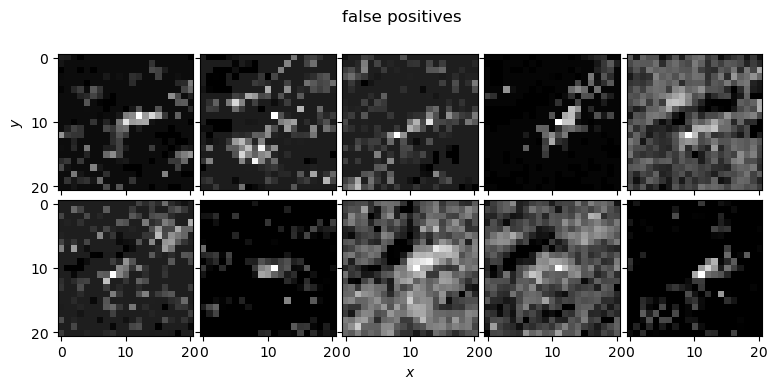

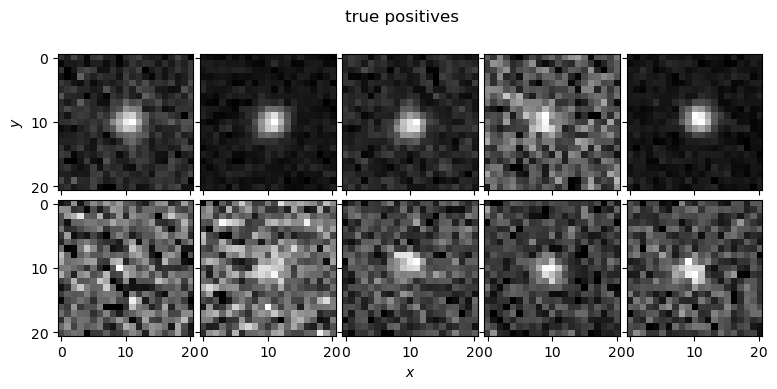

In [21]:
# plot de amostra de imagens
plot_image_array(no_point_source_stamps, title='false positives')
plot_image_array(point_source_stamps, title='true positives')

### Criar uma amostra de treinamento, validação e teste

Usaremos o split_samples do astroML para fazer isso '''split_samples(input_stamps, stamp_class, [0.7,0.1,0.2])''' divide os dados em seleções aleatórias com frações apropriadas de fontes.

In [22]:
from tensorflow.keras.utils import to_categorical
def reshape_arrays(data, labels):
    '''reshape arrays for Keras'''
    data = data.reshape(-1,21, 21, 1)
    labels = to_categorical(labels)
    return data,labels

# combina os falsos positivos e os verdadeiros positivos
input_stamps = np.vstack([no_point_source_stamps, point_source_stamps])
stamp_class = np.zeros(len(no_point_source_stamps) + len(point_source_stamps))
stamp_class[len(no_point_source_stamps):] = 1 # 0 para ruído, 1 para uma estrela

# Divide as amostras em conjuntos de dados de treinamento, validação e teste
(data_train, data_val, data_test), (class_train, class_val, class_test) = split_samples(input_stamps, stamp_class,
                                                                                        [0.7,0.1,0.2])
data_train, class_train = reshape_arrays(data_train, class_train)
data_val, class_val = reshape_arrays(data_val, class_val)
data_test, class_test = reshape_arrays(data_test, class_test)

print ('Número de amostras no treinamento ({}); teste ({}); e validacao ({}) data sets'.format(data_train.shape[0],
                                                                                    data_test.shape[0],
                                                                                   data_val.shape[0]))

Número de amostras no treinamento (76666); teste (21905); e validacao (10952) data sets


## Estruturas de rede neural

O desenvolvimento e o lançamento de bibliotecas de aprendizado profundo de código aberto
tornou o uso de redes neurais profundas acessível a uma ampla gama de
campos. Atualmente, existem dois pacotes comuns: PyTorch (https://pytorch.org) e Tensorflow (https://www.tensorflow.org). Qualquer das duas bases de código pode ser utilizada para as figuras e problemas neste livro (e geralmente eles têm a mesmo funcionalidade).

### TensorFlow:

O Tensorflow é a base de código mais estabelecida com uma grande comunidade
e um grande número de tutoriais (https://www.tensorflow.org/tutorials) e cursos online. Suas
funcionalidades são mais desenvolvidas do que o PyTorch, com ferramentas para visualizar
e inspecionar uma rede (por exemplo, consulte TensorBoard). Por outro lado, a
curva de aprendizado para PyTorch é geralmente considerada mais fácil do que para o Tensorflow, com o PyTorch tendo uma interface orientada a objeto mais natural 
para pessoas acostumadas a escrever código Python.

### PyTorch:

A principal diferença entre o TensorFlow e o PyTorch é que as
redes (ou grafos) que o TensorFlow gera são estáticas, enquanto o
as redes para PyTorch são dinâmicas (consulte TensorFlow Fold para grafos dinâmicos). Isso significa que com o PyTorch pode-se
modificar e ajustar a rede em tempo real (por exemplo, facilitando a
ajustar as alterações na dimensionalidade de entrada ou no número de nós de entrada dentro de uma rede). Esse recurso e o design orientado a objetos do PyTorch geralmente resulta em menos linhas de código para obter o mesmo
quando comparado ao Tensorflow.

### Keras:  

Keras é uma API de alto nível escrita sobre o TensorFlow (e seu precursor Theano). Ele é escrito em Python e fornece uma interface simples e intuitiva ao construir redes neurais. Atualmente, ele é lançado como parte do TensorFlow.

**O que você deve escolher?** Ambas as estruturas estão em constante evolução.
A escolha da biblioteca de aprendizado profundo
se resume a qual você acha que melhor se adapta ao seu estilo de
programação e aprendizagem. Para este tutorial, usaremos o Keras, pois ele possui uma implementação intuitiva dos modelos gráficos ou de rede.

### Construindo uma rede:

Vamos começar definindo o que precisamos para a rede. Começaremos com Keras e

- criar um modelo sequencial (isso significa que adicionamos camadas uma a uma, como vimos em nossa figura introdutória)
- adicionar uma camada densa (totalmente conectada) com 30 neurônios:
- **input_shape** descreve a dimensionalidade do _input data_ a esta primeira camada oculta
- **activation** descreve a função de ativação para os neurônios (neste caso, usaremos 'relu'; unidade linear retificada)
- adicionar uma segunda camada densa (totalmente conectada) com 30 neurônios
- achatar a saída da segunda camada em um único vetor para que possamos usar '''categorical_crossentropy''', pois estamos assumindo que nossas classes são de "codificação one-hot" (ou seja, [1,0] ou [0,1])
- adicionar uma camada de saída usando "softmax" (isso significa que os valores de ativação para cada classe somam 1, para que possam ser tratados como probabilidades) com 2 nós (para nosso exemplo, poderíamos ter usado um único output)

### Treinando a rede
Treinar uma rede neural é conceitualmente simples. Dado um conjunto rotulado
de dados e uma função de perda, precisamos otimizar
os pesos e vieses dentro da rede, minimizando a perda. Uma solução para treinar grandes
redes
usa retropropagação para estimar com eficiência o gradiente da função de perda em relação
aos pesos e vieses.

## Criando uma rede neural com Keras

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Activation
from tensorflow.keras.utils import to_categorical

def simple(input_shape=(21, 21, 1), n_classes: int = 2):

    model = tf.keras.models.Sequential(name='simple')

    # input: imagens de 21x21 pixels com 1 canal -> (21, 21, 1) tensors
    model.add(tf.keras.layers.Dense(30, input_shape=input_shape, activation='relu', name='fc_1'))

    model.add(tf.keras.layers.Dense(30, activation='relu', name='fc_2'))

    model.add(tf.keras.layers.Flatten())
    
    # output layer
    activation = 'sigmoid' if n_classes == 1 else 'softmax'
    model.add(tf.keras.layers.Dense(n_classes, activation=activation, name='fc_out'))

    return model

In [24]:
#Saída da estrutura do modelo
# lembre-se que para cada camada, o número de parâmetros treináveis é:
    # o peso + o viés de cada neurônio
# para o caso de entradas com mais de uma dimensão, como no exemplo (21,21,1),
    # as camadas operam na última dimensão. Por isso a saída se torna (21,21,30).
    # o mesmo não acontece na segunda camada, pois ela também tem 30 neurônios.
    # se tivesse 50 neurônios, seria transformado em (21,21,50).
simple_model = simple()
simple_model.summary()

Model: "simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fc_1 (Dense)                    │ (None, 21, 21, 30)     │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_2 (Dense)                    │ (None, 21, 21, 30)     │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 13230)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_out (Dense)                  │ (None, 2)              │        26,462 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,452 (107.23 KB)

 Trainable params: 27,452 (107.23 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
n_epochs=1
batch_size=1
simple_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
simple_model_history = simple_model.fit(data_train, class_train, epochs=n_epochs, batch_size=batch_size,  verbose=1,
                                        validation_data=(data_val, class_val), shuffle=True)

76666/76666 ━━━━━━━━━━━━━━━━━━━━ 552s 7ms/step - accuracy: 0.6004 - loss: 0.6491 - val_accuracy: 0.7972 - val_loss: 0.3828


### Exercício

**Mini-batch (ou Mini-lote)**: A otimização dos pesos utiliza uma técnica padrão de descida de gradiente (gradient descent). Se a função de perda puder ser expressa em termos de uma soma sobre subconjuntos dos dados de treinamento (por exemplo, como é o caso da norma L2), o treinamento pode ser realizado tanto para o conjunto de dados como um todo, para subconjuntos dos dados (aprendizado em lote ou batch learning), ou para entradas individuais (aprendizado online ou estocástico). A descida de gradiente em lote (Batch gradient descent) considera todos os pontos nos dados e calcula os gradientes médios antes de atualizar os pesos no modelo. A descida de gradiente estocástica (Stochastic gradient descent) pega um único ponto, calcula os gradientes e então atualiza o modelo (e então repete). A descida de gradiente em mini-lote (Mini-batch gradient descent) pega um subconjunto dos dados de treinamento, calcula os gradientes médios e atualiza o modelo (e então repete para todos os mini-lotes).


Experimente usar diferentes valores de épocas e tamanhos de lote para verificar o seu impacto no tempo e na acurácia do treinamento do modelo.

In [26]:
n_epochs=20
batch_size=32
simple_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
simple_model_history = simple_model.fit(data_train, class_train, epochs=n_epochs, batch_size=batch_size,  verbose=1,
                                        validation_data=(data_val, class_val), shuffle=True)

Epoch 1/20
2396/2396 ━━━━━━━━━━━━━━━━━━━━ 120s 50ms/step - accuracy: 0.8981 - loss: 0.3039 - val_accuracy: 0.9050 - val_loss: 0.2927
Epoch 2/20
2396/2396 ━━━━━━━━━━━━━━━━━━━━ 117s 49ms/step - accuracy: 0.9007 - loss: 0.2948 - val_accuracy: 0.9016 - val_loss: 0.2846
Epoch 3/20
2396/2396 ━━━━━━━━━━━━━━━━━━━━ 118s 49ms/step - accuracy: 0.9017 - loss: 0.2874 - val_accuracy: 0.9055 - val_loss: 0.2786
Epoch 4/20
2396/2396 ━━━━━━━━━━━━━━━━━━━━ 116s 48ms/step - accuracy: 0.9052 - loss: 0.2765 - val_accuracy: 0.9105 - val_loss: 0.2742
Epoch 5/20
2396/2396 ━━━━━━━━━━━━━━━━━━━━ 117s 49ms/step - accuracy: 0.9051 - loss: 0.2738 - val_accuracy: 0.9114 - val_loss: 0.2701
Epoch 6/20
2396/2396 ━━━━━━━━━━━━━━━━━━━━ 118s 49ms/step - accuracy: 0.9071 - loss: 0.2709 - val_accuracy: 0.9102 - val_loss: 0.2670
Epoch 7/20
2396/2396 ━━━━━━━━━━━━━━━━━━━━ 116s 49ms/step - accuracy: 0.9066 - loss: 0.2705 - val_accuracy: 0.9126 - val_loss: 0.2642
Epoch 8/20
2396/2396 ━━━━━━━━━━━━━━━━━━━━ 119s 50ms/step - accuracy: 

### Performance da rede

In [27]:
# Usa a rede para prever valores de classe
classes = simple_model.predict(data_test)
print (classes)

685/685 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step
[[1.43e-08 1.00e+00]
 [7.11e-01 2.89e-01]
 [1.00e+00 1.24e-06]
 ...
 [8.14e-01 1.86e-01]
 [2.61e-01 7.39e-01]
 [9.73e-01 2.75e-02]]


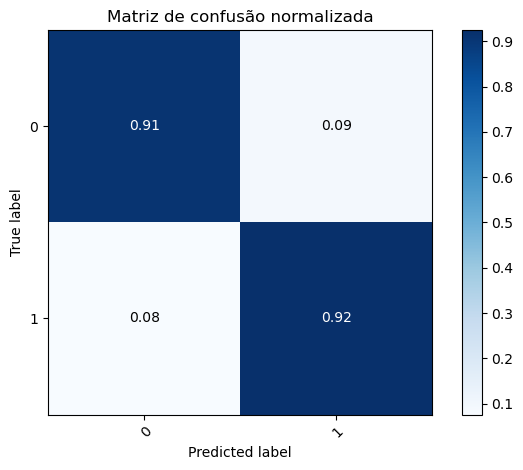

In [28]:
# plota a matriz de confusão
plot_confusion_matrix(np.argmax(class_test,axis=1), np.argmax(classes,axis=1), normalize=True,
                      title='Matriz de confusão normalizada')

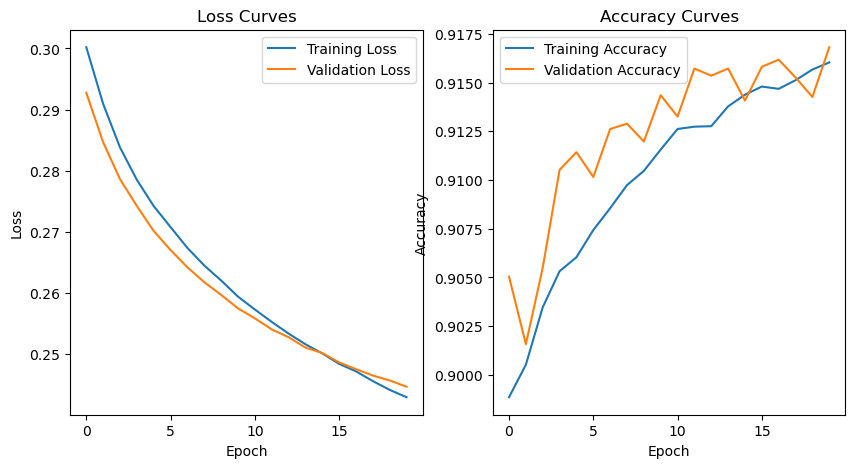

In [29]:
# plot do histórico de treinamento da rede
plot_model_history(simple_model_history)

### Normalização em lote

Nossa primeira otimização sobre a rede neural básica. A normalização em lote dimensiona as ativações de uma camada (observe que normalizamos os dados de entrada) para ter média zero e variância unitária. Na realidade, os dois parâmetros gama (para o desvio padrão) e beta (para a média) são aprendidos pela rede e as ativações multiplicadas/adicionadas por esses parâmetros. A normalização em lote fornece um grau de regularização e permite taxas de aprendizado mais rápidas, pois as saídas são restritas a 0-1 (ou seja, você não obtém grandes excursões nos pesos das camadas subsequentes em uma rede que precisam ser reotimizadas/treinadas).

A normalização é aplicada a minilotes de dados de treinamento (em vez de usar a amostra de treinamento completa)
- adicionar uma camada de normalização em lote:  ```model.add(tf.keras.layers.BatchNormalization(axis = 3, name = 'bn_1'))```



In [30]:
def simpleBN(input_shape=(21, 21, 1), n_classes: int = 2):

    model = tf.keras.models.Sequential(name='simple')

    # input: 21x21 imagens com 1 canal -> (21, 21, 1) tensors.
    model.add(tf.keras.layers.Dense(30, input_shape=input_shape, activation='relu', name='fc_1'))

    model.add(tf.keras.layers.Dense(30, activation='relu', name='fc_2'))

    model.add(tf.keras.layers.BatchNormalization(axis = 3, name = 'bn_1'))
    
    # output layer
    model.add(tf.keras.layers.Flatten())
    activation = 'sigmoid' if n_classes == 1 else 'softmax'
    model.add(tf.keras.layers.Dense(n_classes, activation=activation, name='fc_out'))

    return model

In [31]:
n_epochs=20
simple_model = simpleBN()
simple_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
simple_model_history = simple_model.fit(data_train, class_train, epochs=n_epochs, batch_size=32, verbose=1,
                                        validation_data=(data_val, class_val), shuffle=True)
classes = simple_model.predict(data_test)

Epoch 1/20
2396/2396 ━━━━━━━━━━━━━━━━━━━━ 191s 79ms/step - accuracy: 0.7178 - loss: 0.5544 - val_accuracy: 0.9085 - val_loss: 0.2716
Epoch 2/20
2396/2396 ━━━━━━━━━━━━━━━━━━━━ 190s 79ms/step - accuracy: 0.9095 - loss: 0.2621 - val_accuracy: 0.9144 - val_loss: 0.2458
Epoch 3/20
2396/2396 ━━━━━━━━━━━━━━━━━━━━ 188s 78ms/step - accuracy: 0.9166 - loss: 0.2418 - val_accuracy: 0.9154 - val_loss: 0.2421
Epoch 4/20
2396/2396 ━━━━━━━━━━━━━━━━━━━━ 190s 79ms/step - accuracy: 0.9172 - loss: 0.2386 - val_accuracy: 0.9125 - val_loss: 0.2427
Epoch 5/20
2396/2396 ━━━━━━━━━━━━━━━━━━━━ 188s 79ms/step - accuracy: 0.9161 - loss: 0.2358 - val_accuracy: 0.9148 - val_loss: 0.2432
Epoch 6/20
2396/2396 ━━━━━━━━━━━━━━━━━━━━ 190s 79ms/step - accuracy: 0.9171 - loss: 0.2333 - val_accuracy: 0.9146 - val_loss: 0.2448
Epoch 7/20
2396/2396 ━━━━━━━━━━━━━━━━━━━━ 190s 79ms/step - accuracy: 0.9169 - loss: 0.2284 - val_accuracy: 0.9132 - val_loss: 0.2445
Epoch 8/20
2396/2396 ━━━━━━━━━━━━━━━━━━━━ 188s 78ms/step - accuracy: 

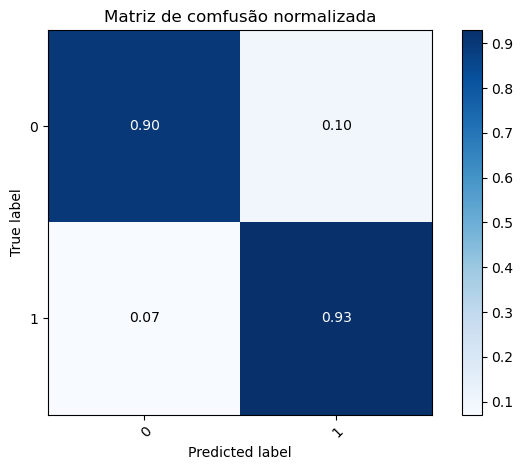

In [32]:
# Plot da matriz e confusão
plot_confusion_matrix(np.argmax(class_test,axis=1), np.argmax(classes,axis=1), normalize=True,
                      title='Matriz de comfusão normalizada')

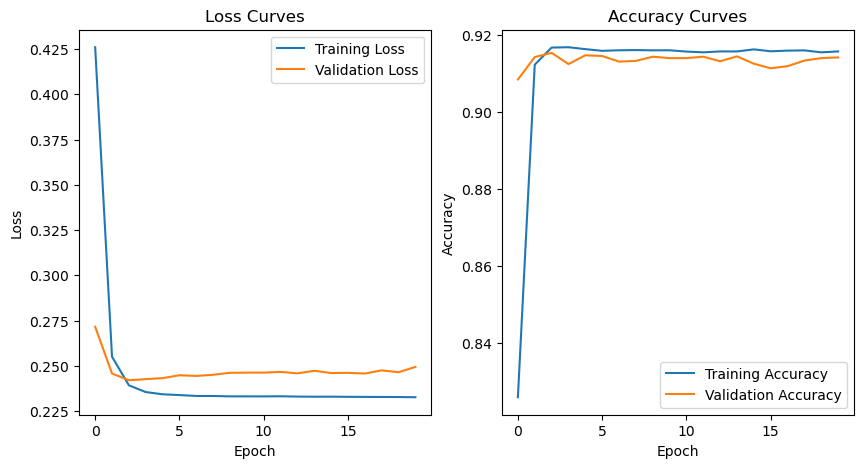

In [33]:
plot_model_history(simple_model_history)

### Redes Convolucionais

Redes Neurais Convolucionais ou
CNNs são redes projetadas para trabalhar com imagens ou com qualquer
conjunto de dados amostrado. As CNNs reduzem a complexidade da rede ao
exigir que os neurônios respondam apenas a entradas de um subconjunto de uma
imagem (o campo receptivo). Isso imita a operação do visual
córtex, onde os neurônios respondem apenas a uma pequena parte do
campo de visão.

Existem quatro componentes principais para uma CNN:
- uma camada convolucional,
- uma _função de ativação não linear_ ,
- uma operação de pooling ou de redução da amostra, e
- uma _camada totalmente conectada para classificação_

Dependente da complexidade da rede ou da estrutura dos dados,
esses componentes podem ocorrer singularmente ou encadeados em várias
sequências.

![Convolutional Neural Network](https://www.astroml.org/astroML-notebooks/_images/fig_cnn_1.png)

**Convolução** em uma CNN refere-se à convolução dos dados de entrada $I(x,y)$ com um kernel $K(x,y)$ que produzirá um mapa de recursos $F(x,y)$
\begin{equation} F(x,y) = K(x,y) * I(x,y) = \sum_{x_0} \sum_{y_0} I(x-x_0, y-y_0) K(x_0, y_0). \end{equation} O kernel responde apenas a pixels dentro de seu campo receptivo (ou seja, o tamanho do kernel), reduzindo a complexidade computacional da rede resultante. Os kernels na convolução são descritos por uma profundidade (o número de kernels, $K$, aplicado à imagem) e um passo (quantos pixels um kernel desloca em cada etapa da convolução; normalmente um). Dada uma imagem $N\times M$, o resultado da etapa de convolução é transformar uma única imagem em um cubo de dados de mapas de recursos com uma dimensão $N \times M \times K$. 


Uma vez **aprendidos**, os kernels dentro da camada convolucional podem aparecer como operações fisicamente intuitivas nas imagens, como filtros de detecção de borda.

Tal como acontece com as redes neurais tradicionais, uma função de ativação não linear é aplicada aos pixels individuais nos mapas de recursos resultantes.

O **pooling** na CNN reduz ou subamostra os mapas de recursos. O pooling resume os valores dentro de uma região
de interesse (por exemplo, uma janela de 2x2 pixels). O resumo pode ser a média
valor de pixel, mas mais comumente o valor máximo de pixel é preservado
(Max Pooling) na redução da amostragem. Este agrupamento dos mapas de recursos
reduz o tamanho da rede resultante e torna a rede menos
sensível a pequenas translações ou distorções entre imagens.

A camada final de uma CNN é a camada de classificação que mapeia o
saída da CNN para um conjunto de rótulos. Normalmente, isso é uma camada totalmente
 conectada onde cada saída
da camada final de agrupamento se conecta a todos os neurônios na
camada de classificação.


### CNNs: Aumentando a complexidade da arquitetura com VGG16

Vamos começar com uma arquitetura de rede simples do Grupo de Geometria Visual de Oxford. VGG16 é uma rede muito simples que tem um bom desempenho em competições tradicionais de classificação de imagens (por exemplo, aquelas que usam os dados ImageNet)

In [34]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.utils import to_categorical

def vgg16(input_shape=(21, 21, 1), n_classes: int = 2):
    """
        VGG16
    :param input_shape:
    :param n_classes:
    :return:
    """

    model = tf.keras.models.Sequential(name='VGG16')
    # input: 21x21 imagens com 1 canal -> (21, 21, 1) tensors.
    # aplica 16 filtros convolucionais de dimensão 3x3 cada.
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape, name='conv1'))
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', name='conv2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv3'))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv4'))
    model.add(tf.keras.layers.BatchNormalization(axis = 3, name = 'bn_2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 4)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(256, activation='relu', name='fc_1'))
    model.add(tf.keras.layers.Dropout(0.5))
    # output layer
    activation = 'sigmoid' if n_classes == 1 else 'softmax'
    model.add(tf.keras.layers.Dense(n_classes, activation=activation, name='fc_out'))

    return model

### O uso de camadas de dropout

À medida que aumentamos a complexidade da rede, nos deparamos com o problema de sobreajustar os dados (como visto em muitos dos exemplos de astroML). A camada de dropout ```model.add(tf.keras.layers.Dropout(0.5))``` em cada época de treinamento define aleatoriamente um neurônio como 0 com uma probabilidade de 0,5. Há um debate sobre se a camada de dropout deve vir antes ou depois de uma camada de ativação, mas uma regra geral recomendada é que ela deve vir depois da camada de ativação para funções de ativação diferentes de relu.

In [35]:
vgg_model = vgg16()
vgg_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
n_epochs=15
vgg_model.summary()
vgg_model_history = vgg_model.fit(data_train, class_train, epochs=n_epochs, batch_size=1024, verbose=2,
                                  validation_data=(data_val, class_val), shuffle=True)
classes = vgg_model.predict(data_test)

Model: "VGG16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 19, 19, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 17, 17, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 6, 6, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 4, 4, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 4, 4, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_1 (Dense)                    │ (None, 256)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_out (Dense)                  │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,458 (99.45 KB)

 Trainable params: 25,394 (99.20 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/15
75/75 - 106s - 1s/step - accuracy: 0.5795 - loss: 0.6868 - val_accuracy: 0.5469 - val_loss: 0.6898
Epoch 2/15
75/75 - 105s - 1s/step - accuracy: 0.5763 - loss: 0.6823 - val_accuracy: 0.5469 - val_loss: 0.6883
Epoch 3/15
75/75 - 106s - 1s/step - accuracy: 0.5728 - loss: 0.6801 - val_accuracy: 0.5469 - val_loss: 0.6873
Epoch 4/15
75/75 - 104s - 1s/step - accuracy: 0.5780 - loss: 0.6776 - val_accuracy: 0.5469 - val_loss: 0.6862
Epoch 5/15
75/75 - 107s - 1s/step - accuracy: 0.5840 - loss: 0.6753 - val_accuracy: 0.5469 - val_loss: 0.6842
Epoch 6/15
75/75 - 102s - 1s/step - accuracy: 0.5968 - loss: 0.6722 - val_accuracy: 0.5469 - val_loss: 0.6818
Epoch 7/15
75/75 - 106s - 1s/step - accuracy: 0.6024 - loss: 0.6694 - val_accuracy: 0.5469 - val_loss: 0.6813
Epoch 8/15
75/75 - 107s - 1s/step - accuracy: 0.6170 - loss: 0.6643 - val_accuracy: 0.5469 - val_loss: 0.7024
Epoch 9/15
75/75 - 108s - 1s/step - accuracy: 0.6163 - loss: 0.6621 - val_accuracy: 0.5469 - val_loss: 0.6873
Epoch 10/1

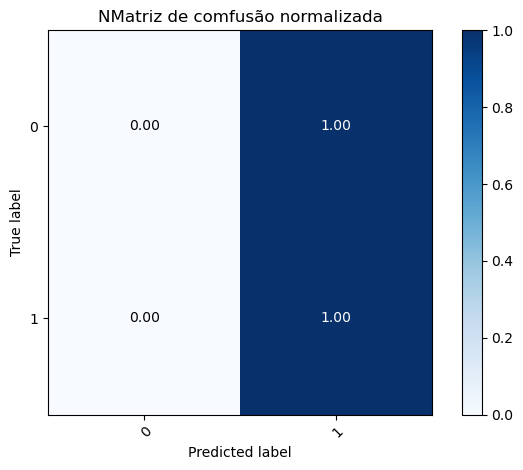

In [36]:
# plot da matriz de confusão
plot_confusion_matrix(np.argmax(class_test,axis=1), np.argmax(classes,axis=1), normalize=True,
                      title='NMatriz de comfusão normalizada')

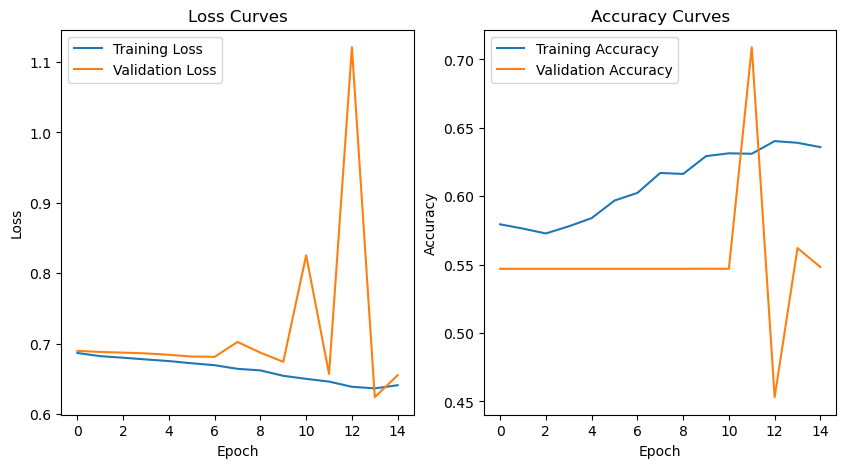

In [37]:
# plot a história do treinamento
plot_model_history(vgg_model_history)

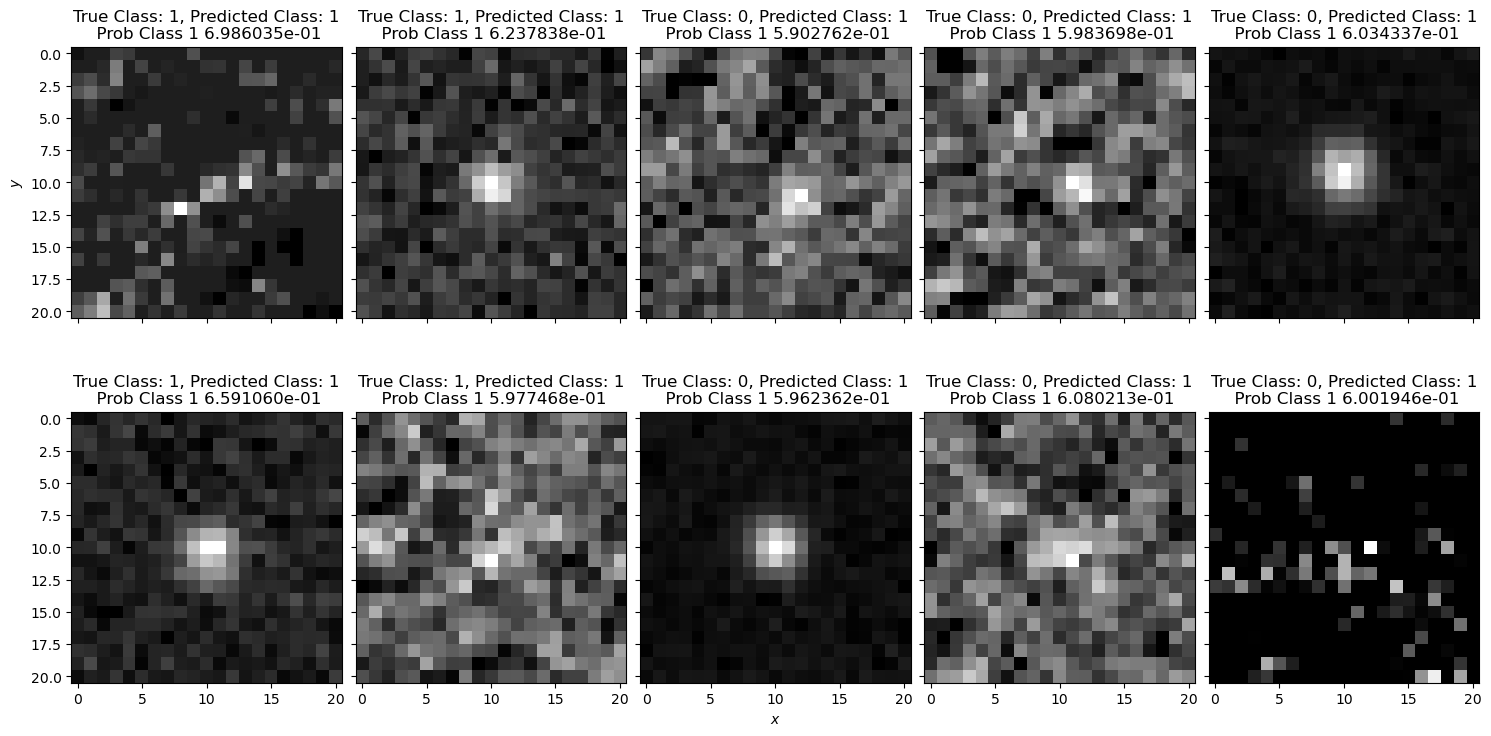

In [38]:
# plot dos exemplos de classificação
plot_image_array(data_val, figsize=[16,10], subtitle=True, classes=classes, class_true=class_test)

### Interpretando redes: quantas camadas e quantos neurônios?

O número de camadas, o número de neurônios em uma camada e
a conectividade dessas camadas é normalmente descrita como a arquitetura da rede.

Abordagens para definir uma
arquitetura de rede se tornam mais tentativa e erro do que aplicar um
conjunto de princípios. Para um ponto de partida, no entanto, existem relativamente
poucos problemas que se beneficiam significativamente de mais de duas camadas e
Recomendamos começar com uma única camada ao treinar um
rede e usando validação cruzada para determinar quando camadas adicionais
resultam em overfit.
Tal como acontece com o número de camadas, o número de neurônios dentro de uma camada
leva a custos computacionais (e exige
conjuntos de treinamento para evitar o overffiting dos dados). Existem muitas
propostas de regras práticas para definir uma arquitetura de rede:
- o número de neurônios deve estar entre o número de nós de entrada e saída
- O número de neurônios deve ser igual ao número de saídas mais 2/3 do número de nós de entrada.
- o número de neurônios na camada oculta deve ser menor que o dobro do tamanho das camadas de entrada.

### Interpretando redes: onde uma rede está olhando

Mapas de ocultação, mapas de saliência, mapas de ativação de classe são todas técnicas para expressar quais pixels contribuem para a classificação. Essas são tentativas de reduzir a natureza de "caixa preta" das redes. O mais simples deles é o mapa de oclusão, onde partimos uma imagem e calculamos a probabilidade de dessa parte pertencer a uma classe. Se a probabilidade diminuir, a parte ocluída da imagem é considerada importante. Se não houver alteração na probabilidade, os pixels ocluídos não são considerados importantes. Uma implementação simples disso é mostrada aqui.

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


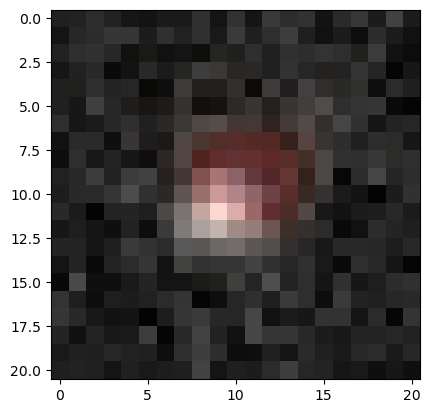

In [39]:
model = vgg_model
image_number = 11

kernel_size=5
input_stamp = data_test[image_number].reshape(21,21)
i = 0
j=0
heatmap = []
keras_stamps = []
for j in range(22-kernel_size):
    for i in range(22-kernel_size):
        img = np.copy(input_stamp)
        img[i:i+kernel_size,j:j+kernel_size] = 0
        img = normalize_image(img)
        keras_stamps.append(img)
keras_stamps = np.array(keras_stamps).reshape([-1,21,21,1])
probs = 1. - model.predict(keras_stamps)
heatmap = probs[:,1].reshape(22-kernel_size,22-kernel_size)

def transparent_cmap(cmap, N=255):
    "Copy colormap and set alpha values"
    mycmap = cmap
    mycmap._init()
    mycmap._lut[:,-1] = np.linspace(0, 0.8, N+4)
    return mycmap

# pad heatmap to same size as original image
heatmap = np.pad(heatmap, pad_width=np.int64(kernel_size/2), mode='minimum')

# use the base cmap to create transparent overlay
mycmap = transparent_cmap(plt.cm.Reds)
fig, ax = plt.subplots(nrows=1,ncols=1)
ax.imshow(data_test[image_number].reshape(21,21), cmap='gray')
ax.imshow(np.array(heatmap), alpha=0.5, cmap=mycmap)